In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,KFold,cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc,confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.decomposition import PCA

<h4>Data processing for machine learning algorithm</h4>

In [2]:
df=pd.read_csv('data/final_data.csv')
del df['Unnamed: 0']
del df['boolDeadRelations']
del df['age']
del df['isNoble']

df.set_index('name',inplace=True)

# get dummy varibles for ordinal varibles
culture_dummy=pd.get_dummies(df['culture'],prefix='Culture') #Nan value will be ingored automatically
df[culture_dummy.columns]=culture_dummy
del df['culture']

house_dummy=pd.get_dummies(df['house'],prefix='House')
df[house_dummy.columns]=house_dummy
del df['house']

identity_dummy=pd.get_dummies(df['identity'])
df[identity_dummy.columns]=identity_dummy
del df['identity']  
del df['lord']  #delete one column to eliminate the linear relationships
print(df.shape)
#get the attribute set and label set
X=df.drop('isAlive',axis=1)
Y=df['isAlive']

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.15)
print(X_train.shape)
print(X_test.shape)

(1946, 383)
(1654, 382)
(292, 382)


In [3]:
# use PCA method to lower the dimension
pca = PCA(0.95)
x_total = df.drop(columns=['isAlive'])
lower_dimensional_x = pca.fit_transform(x_total)
df_pca_features = pd.DataFrame(data=lower_dimensional_x ,
          index=list(df.index),
          columns=np.arange(lower_dimensional_x.shape[1]))
df_pca_features['isAlive'] = df[['isAlive']].values
df_concat = df_pca_features
# df_concat = pd.concat([df_pca_features,pd.DataFrame(df[['isAlive']])])
# print(df_concat.shape)
train, test = train_test_split(df_concat,test_size=0.15)
x_train_pca = train.drop(columns=['isAlive'])
y_train_pca = train[['isAlive']]
x_test_pca = test.drop(columns=['isAlive'])
y_test_pca = test[['isAlive']]
y_train_pca = y_train_pca.values.ravel()
y_test_pca = y_test_pca.values.ravel()
print(x_train_pca.shape)
print(x_test_pca.shape)

(1654, 89)
(292, 89)


In [4]:
print(x_train_pca.head())

                                           0         1         2         3   \
Alysanne Targaryen                  -0.300497  0.983271 -0.230803  0.187925   
Coldhands                           -0.283221 -0.507163  0.325134 -0.359330   
Baelon Targaryen (son of Viserys I) -0.266947  0.841108 -0.262984 -0.623374   
Cynthea Frey                        -0.310819 -0.798025 -0.988456  0.290093   
Daughter of the Dusk                -0.422367  0.686349 -0.564853  0.779893   

                                           4         5         6         7   \
Alysanne Targaryen                   0.106758 -0.161219  0.495358  0.226462   
Coldhands                           -0.868015 -0.109815 -0.267061  0.414483   
Baelon Targaryen (son of Viserys I)  0.512033 -0.422171 -0.226013 -0.053429   
Cynthea Frey                         0.899440  0.206407 -0.271135  0.252122   
Daughter of the Dusk                -0.581888  0.431260 -0.100050 -0.408976   

                                           8      

<h4>K_nearest neighbors algorithm</h4>

In [5]:
def validate_model(model,K,X,Y):    #cross validation
    folder=KFold(K,shuffle=True)
    folds=folder.split(X,Y)
    val_error=0.0
    fold_count=0
    for fold in folds:
        train_idx,val_idx=fold
        x_train=X.iloc[train_idx]
        y_train=Y[train_idx]
        x_val=X.iloc[val_idx]
        y_val=Y[val_idx]     
        model.fit(x_train,y_train)
        y_pred=model.predict(x_val)
        val_err=np.mean(y_val==y_pred)
        val_error+=val_err
        fold_count+=1
    return val_error/K

In [6]:
base_model=KNeighborsClassifier(n_neighbors=3)
score=validate_model(base_model,5,x_train_pca,y_train_pca)  

In [7]:
#choose the best k for the model
accuracy=np.array([])  
for k in range(3,20):
    base_model=KNeighborsClassifier(n_neighbors=k)
    score=validate_model(base_model,5,x_train_pca,y_train_pca)  #use 5-fold
    accuracy=np.append(accuracy,score)

the best_k is 9
the accuracy of knn is 0.791095890410959
[[ 21  10]
 [ 51 210]]


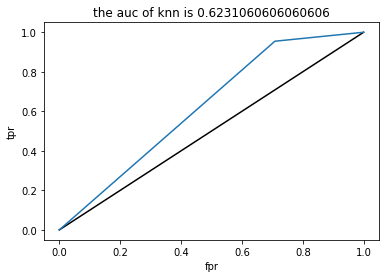

In [8]:
best_k=accuracy.argmax()+3
print(f'the best_k is {best_k}')
knn_best_model=KNeighborsClassifier(n_neighbors=best_k).fit(x_train_pca,y_train_pca)
Y_pre=knn_best_model.predict(x_test_pca)
print(f'the accuracy of knn is {np.mean(Y_pre==y_test_pca)}')
matrix=confusion_matrix(Y_pre,y_test_pca)
print(matrix)
(fpr, tpr, thresholds) = roc_curve(y_test_pca,Y_pre)
area = auc(fpr,tpr)
plt.title(f'the auc of knn is {area}')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.plot([0, 1], [0, 1], 'k')
plt.plot(fpr,tpr)

<h4>Naive Bayes<h4>

In [9]:
NB_model1 = MultinomialNB(alpha=1) #use Multinomial Naive Bayes, let alpha=1 (Laplace Smoothing)
NB_model1.fit(X_train,Y_train)
NB_model2 = BernoulliNB() #use BernouliNB to predict
NB_model2.fit(X_train,Y_train) 
print(accuracy_score(Y_test,NB_model1.predict(X_test)))
print(accuracy_score(Y_test,NB_model2.predict(X_test))) 
#contrast

0.7876712328767124
0.7773972602739726


<h4>Decision Tree<h4>

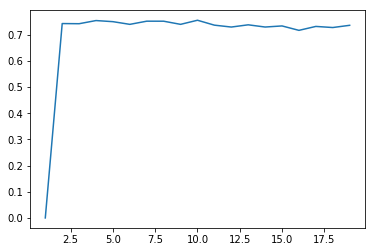

In [10]:
performance=np.repeat(0.0,19)
for k in range(2,20): #We are trying to find the best depth of the decision tree in case overfitting 
    decision_tree_model = tree.DecisionTreeClassifier(max_depth=k) 
    avg_performance=(validate_model(decision_tree_model,k,x_train_pca,y_train_pca))
    performance[k-1]=avg_performance
outcomes=np.arange(1,20)
plt.plot(outcomes,performance)

In [11]:
decision_tree_model = tree.DecisionTreeClassifier(max_depth=10)
#Roughly, the best max depth is 10
decision_tree_model.fit(x_train_pca,y_train_pca)
accuracy_score(y_test_pca, decision_tree_model.predict(x_test_pca))

0.7876712328767124

<h4>Random Forrest<h4>

In [12]:
from sklearn.ensemble import RandomForestClassifier

RFC_model = RandomForestClassifier(n_estimators=10)
RFC_model.fit(x_train_pca,y_train_pca)
accuracy_score(y_test_pca, RFC_model.predict(x_test_pca))
#random forrest's algorithm

0.7636986301369864




<h4>SVM<h4>

In [13]:
from sklearn.svm import SVC

In [14]:
performance=np.repeat(0.0,50)
k=0
for c in np.arange(2,102,2):
    SVM_model = SVC(kernel='rbf',C=c,gamma='auto')
    SVM_model.fit(x_train_pca,y_train_pca)
    performance[k]=accuracy_score(y_test_pca, SVM_model.predict(x_test_pca))
    k+=1
#we will use this loop to determine c value(regularizaiton)

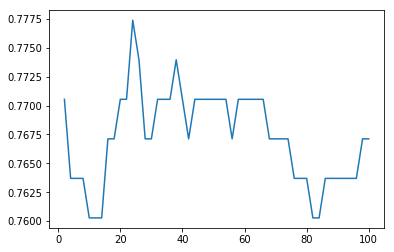

In [15]:
outcomes=np.arange(2,102,2)
plt.plot(outcomes,performance)

In [16]:
SVM_model = SVC(kernel='rbf',C=20,gamma='auto')
SVM_model.fit(x_train_pca,y_train_pca)
accuracy_score(y_test_pca, SVM_model.predict(x_test_pca))
#seems 20 is a good choise

0.7705479452054794

In [17]:
confusion_matrix(y_test_pca,SVM_model.predict(x_test_pca))

array([[ 10,  62],
       [  5, 215]])

<h4>Logistic Regression</h4>

In [18]:
Logis_model=LogisticRegression(solver='liblinear').fit(x_train_pca,y_train_pca)
y_pre=Logis_model.predict(x_test_pca)
print(f'the accuracy of LogisticRegression is {np.mean(y_pre==y_test_pca)}')

the accuracy of LogisticRegression is 0.773972602739726


<BarContainer object of 10 artists>

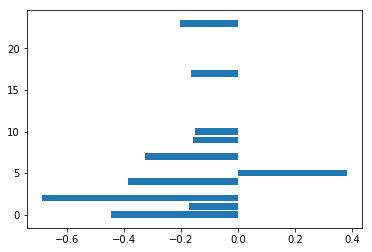

In [19]:
#calculate the importance of each attribute
feature_importance=Logis_model.coef_.ravel()*np.std(x_train_pca,axis=0)
#find the most ten important factors
index=feature_importance[abs(feature_importance).argsort()[::-1][:10]].index
plt.barh(index,feature_importance[abs(feature_importance).argsort()[::-1][:10]])

[[ 23  17]
 [ 49 203]]


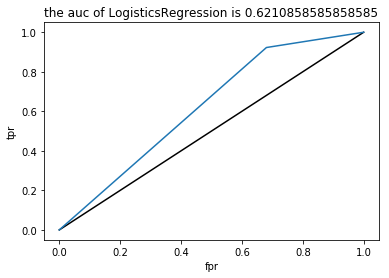

In [20]:
matrix=confusion_matrix(y_pre,y_test_pca)
print(matrix)
(fpr, tpr, thresholds) = roc_curve(y_test_pca,y_pre)
area = auc(fpr,tpr)
plt.title(f'the auc of LogisticsRegression is {area}')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.plot([0, 1], [0, 1], 'k')
plt.plot(fpr,tpr)

<h4>Predict the death probability for the main characters</h4>

In [21]:
#Get the data we need to predict
name=['Sansa Stark','Tyrion Lannister','Jon Snow','Daenerys Targaryen','Jaime Lannister','Bran Stark', 'Arya Stark','Cersei Lannister']
X_prediction=df_concat.loc[name].drop('isAlive',axis=1)
Y_prediction=df_concat.loc[name]['isAlive']
death_prob=Logis_model.predict_proba(X_prediction)
pd.DataFrame(death_prob,index=name,columns=['Death','Alive']).sort_values(by='Death')

Death     Alive
Sansa Stark         0.428613  0.571387
Jon Snow            0.429105  0.570895
Arya Stark          0.431353  0.568647
Bran Stark          0.564575  0.435425
Cersei Lannister    0.660404  0.339596
Jaime Lannister     0.677778  0.322222
Tyrion Lannister    0.836870  0.163130
Daenerys Targaryen  0.864804  0.135196